# 不動産価格予測コンペ(Nishika)

- [コンペURL](https://www.nishika.com/competitions/20/summary)

## 目的

- 国内の中古マンションの価格推定

### 設定

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


必要なライブラリーのインストール

In [ ]:
!pip install optuna xfeat japanize-matplotlib catboost==0.26 >> /dev/null

In [ ]:
# パスの設定
My_PATH = "/content/drive/MyDrive/property_values_prediction"
%cd {My_PATH}

/content/drive/MyDrive/property_values_prediction


zipファイルの解凍

In [ ]:
# data.zipファイルの解凍
# 古いdataのディレクトリ削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/　　>> /dev/null

import zipfile
with zipfile.ZipFile('data.zip', 'r')as f:
    f.extractall('./data')

# train.zipの解凍
# 古いtrainディレクトリの削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/train/ >> /dev/null

with zipfile.ZipFile('data/train.zip', 'r')as f:
    f.extractall('./data/')

outputディレクトリの作成

In [ ]:
import datetime
import os

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")
dir_for_output = "./output/" + current_time

os.makedirs(dir_for_output, exist_ok=True)

In [ ]:
import re

import japanize_matplotlib
import catboost as cb
from catboost import CatBoost, Pool
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (
    SelectCategorical,
    LabelEncoder,
    LambdaEncoder,
    Pipeline,
    ConcatCombination,
    SelectNumerical,
    ArithmeticCombinations,
    TargetEncoder,
    aggregation,
    GBDTFeatureSelector,
    GBDTFeatureExplorer,
)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(
    action="ignore", category=pd.core.common.SettingWithCopyWarning
)

各種関数の設定

In [ ]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

コンペデータ作成（利用カラム、目的変数など決める）

In [ ]:
BASE_PATH = './data/'
RANDOM_STATE = 10

In [ ]:
paths = glob(BASE_PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,1047763,中古マンション等,NaN,1107,北海道,札幌市西区,西野１条,発寒南,10,３ＬＤＫ,65,NaN,NaN,NaN,昭和53年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2020年第２四半期,改装済,NaN,6.991226
1,1003151,中古マンション等,NaN,1101,北海道,札幌市中央区,北１１条西,桑園,5,４ＬＤＫ,80,NaN,NaN,NaN,平成7年,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2018年第２四半期,未改装,NaN,7.278754
2,1004084,中古マンション等,NaN,1101,北海道,札幌市中央区,南１条西,円山公園,6,１Ｒ,20,NaN,NaN,NaN,昭和51年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2012年第１四半期,未改装,NaN,6.361728
3,1056515,中古マンション等,NaN,1107,北海道,札幌市西区,八軒５条西,発寒中央,12,３ＬＤＫ,70,NaN,NaN,NaN,平成6年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種中高層住居専用地域,60.0,200.0,2014年第１四半期,改装済,NaN,7.079181
4,1001193,中古マンション等,NaN,1101,北海道,札幌市中央区,北２条西,西１８丁目,6,３ＬＤＫ,75,NaN,NaN,NaN,平成23年,ＲＣ,NaN,住宅,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2019年第３四半期,未改装,NaN,7.505150


In [ ]:
# 欠損値の確認
train_df.isnull().sum()

ID                   0
種類                   0
地域              677392
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                660
最寄駅：名称            2672
最寄駅：距離（分）        23098
間取り              23661
面積（㎡）                0
土地の形状           677392
間口              677392
延床面積（㎡）         677392
建築年              19622
建物の構造            16486
用途               58246
今後の利用目的         364049
前面道路：方位         677392
前面道路：種類         677392
前面道路：幅員（ｍ）      677392
都市計画             19221
建ぺい率（％）          23345
容積率（％）           23345
取引時点                 0
改装               61966
取引の事情等          658854
取引価格（総額）_log         0
dtype: int64

In [ ]:
# 提出フォーマットの読み込み
sub_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [ ]:
ID = 'ID'
TARGET = '取引価格（総額）_log'

In [ ]:
df = pd.concat([train_df, test_df])

In [ ]:
# 解析対象外のカラムを指定
rm_cols = []
rm_cols += ['市区町村コード']

# ユニーク数が1以下のカラムを解析対象外のカラムとして指定
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [ ]:
# テストデータの目的変数が無いため、np.nan で埋める
test_df[TARGET] = np.nan

# 解析対象外のカラムを削除する
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)

# 解析対象に使用するDataFrameを作成
df = pd.concat([train_df, test_df])

# 取引時点(売買契約/四半期単位)でソートし、indexを振り直す
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [ ]:
# 取引時点(売買契約/四半期単位)のユニークを確認
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [ ]:
# valid, testデータのインデックスを指定
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [ ]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

特徴量生成

In [ ]:
# 取引時点(売買契約/四半期単位)を順序尺度に変換
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62


In [ ]:
# 都道府県別の取引時点(売買契約/四半期単位)別の平均売買件数を算出
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836443,
 '京都府': 7.15593584855535,
 '佐賀県': 7.009937258263499,
 '兵庫県': 7.157742870483325,
 '北海道': 6.965967793677889,
 '千葉県': 7.155825324965048,
 '和歌山県': 7.0226902108157585,
 '埼玉県': 7.169744271396765,
 '大分県': 6.911537826573121,
 '大阪府': 7.158352973821433,
 '奈良県': 7.0568846102346985,
 '宮城県': 7.03954425380504,
 '宮崎県': 6.958678653711221,
 '富山県': 7.046920071386999,
 '山口県': 7.045342730349815,
 '山形県': 7.087990602814885,
 '山梨県': 6.848839888686703,
 '岐阜県': 7.078095913486438,
 '岡山県': 7.038090734927505,
 '岩手県': 6.92500267906058,
 '島根県': 7.16537621470031,
 '広島県': 7.09344902165506,
 '徳島県': 6.912051981629739,
 '愛媛県': 6.9664330115966635,
 '愛知県': 7.107301969238665,
 '新潟県': 6.913835156235099,
 '東京都': 7.377929204637786,
 '栃木県': 6.950636958071022,
 '沖縄県': 7.160046604428345,
 '滋賀県': 7.166026958168428,
 '熊本県': 6.970182251843288,
 '石川県': 6.929363348877184,
 '神奈川県': 7.258118267209654,
 '福井県': 6.979575815840192,
 '福岡県': 6.9922649050422665,
 '福島県': 6.974380579140183,
 '秋田県': 6.94131374711262,
 

In [ ]:
# 都道府県別の取引時点(売買契約/四半期単位)別平均売買件数を追加
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62,7.124361
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62,7.396885
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62,7.161930


In [ ]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
df.head()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,大阪府,大阪市旭区,新森,森小路,6.0,１ＬＤＫ,50,1974.0,ＲＣ,住宅,NaN,準工業地域,80.0,200.0,改装済,NaN,7.041393,0,0.0,16
1,14289301,神奈川県,川崎市高津区,千年新町,武蔵新城,7.0,３ＬＤＫ,60,1992.0,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,改装済,NaN,7.361728,0,0.0,16
2,13417040,東京都,葛飾区,宝町,お花茶屋,NaN,２ＬＤＫ,60,1993.0,ＲＣ,住宅,NaN,準工業地域,60.0,200.0,改装済,NaN,7.255273,0,0.0,16
3,14267697,神奈川県,横浜市青葉区,あざみ野,あざみ野,NaN,３ＬＤＫ,85,1982.0,NaN,住宅,NaN,NaN,NaN,NaN,NaN,NaN,7.556303,0,0.0,16
4,13386603,東京都,練馬区,豊玉北,練馬,5.0,１Ｋ,20,2005.0,ＲＣ,住宅,NaN,商業地域,80.0,500.0,未改装,NaN,7.278754,0,0.0,16


In [ ]:
# 数値データのみを抽出(xfeat)
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,6.0,50,1974.0,80.0,200.0,7.041393,0,0.0,16
1,14289301,7.0,60,1992.0,60.0,200.0,7.361728,0,0.0,16


In [ ]:
# カテゴリデータのラベルエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,0,-1


In [ ]:
# 面積×容積率を計算
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,100.0
1,120.0


In [ ]:
encoder = Pipeline([
                    SelectCategorical(exclude_cols=[]),
                    ConcatCombination(drop_origin=True, output_suffix="", r=2),
                    LabelEncoder(output_suffix=""),
                    ])

cal_comb_df = encoder.fit_transform(df)
cal_comb_df.head(2)

,都道府県名市区町村名,都道府県名地区名,都道府県名最寄駅：名称,都道府県名間取り,都道府県名建物の構造,都道府県名用途,都道府県名今後の利用目的,都道府県名都市計画,都道府県名改装,都道府県名取引の事情等,市区町村名地区名,市区町村名最寄駅：名称,市区町村名間取り,市区町村名建物の構造,市区町村名用途,市区町村名今後の利用目的,市区町村名都市計画,市区町村名改装,市区町村名取引の事情等,地区名最寄駅：名称,地区名間取り,地区名建物の構造,地区名用途,地区名今後の利用目的,地区名都市計画,地区名改装,地区名取引の事情等,最寄駅：名称間取り,最寄駅：名称建物の構造,最寄駅：名称用途,最寄駅：名称今後の利用目的,最寄駅：名称都市計画,最寄駅：名称改装,最寄駅：名称取引の事情等,間取り建物の構造,間取り用途,間取り今後の利用目的,間取り都市計画,間取り改装,間取り取引の事情等,建物の構造用途,建物の構造今後の利用目的,建物の構造都市計画,建物の構造改装,建物の構造取引の事情等,用途今後の利用目的,用途都市計画,用途改装,用途取引の事情等,今後の利用目的都市計画,今後の利用目的改装,今後の利用目的取引の事情等,都市計画改装,都市計画取引の事情等,改装取引の事情等
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0


In [ ]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(
        df,
        group_key=group_col,
        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
        agg_methods=['count', 'mean', 'min', 'max', 'median', 'std'],
        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_median_最寄駅：距離（分）_grpby_市区町村名,agg_median_面積（㎡）_grpby_市区町村名,agg_median_建ぺい率（％）_grpby_市区町村名,agg_median_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,789,808,806,806,8.206591,59.814356,70.397022,236.228288,0.0,15,60.0,200.0,23.0,115,80.0,400.0,8.0,60.0,80.0,200.0,4.327536,16.170642,9.998320,61.473966
1,2945,3089,2872,2872,13.020713,59.043380,61.922006,212.580084,0.0,15,40.0,80.0,105.0,550,80.0,1100.0,10.0,65.0,60.0,200.0,10.878025,23.045336,6.448643,56.522903


In [ ]:
feat_df = pd.concat([num_df,le_df,num_comb_df,cal_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(700543, 101)


In [ ]:
feat_df.dtypes

ID                                 int64
最寄駅：距離（分）                        float64
面積（㎡）                              int64
建築年                              float64
建ぺい率（％）                          float64
                                  ...   
agg_median_容積率（％）_grpby_市区町村名    float64
agg_std_最寄駅：距離（分）_grpby_市区町村名    float64
agg_std_面積（㎡）_grpby_市区町村名        float64
agg_std_建ぺい率（％）_grpby_市区町村名      float64
agg_std_容積率（％）_grpby_市区町村名       float64
Length: 101, dtype: object

モデル構築

In [ ]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 101) (24899, 101) (23151, 101)


In [ ]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [ ]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [ ]:
def objective(trial):

    param = {
        "iterations": 3000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.01, 100.00
        ),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "task_type": "GPU",
    }

    model = cb.CatBoostRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=100,
        verbose_eval=500,
    )

    preds = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds)

    return mae

In [ ]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(
    direction="minimize", sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50)

[I 2021-11-30 11:30:23,117] A new study created in memory with name: no-name-abd2becc-9314-4b02-b01b-12949b0f6ccf


0:	learn: 0.3526593	test: 0.3613325	best: 0.3613325 (0)	total: 59.3ms	remaining: 2m 57s
500:	learn: 0.1720097	test: 0.1787248	best: 0.1787248 (500)	total: 26.8s	remaining: 2m 13s
1000:	learn: 0.1593201	test: 0.1648138	best: 0.1648138 (1000)	total: 51.7s	remaining: 1m 43s
1500:	learn: 0.1518675	test: 0.1564473	best: 0.1564473 (1500)	total: 1m 16s	remaining: 1m 16s
2000:	learn: 0.1457032	test: 0.1504042	best: 0.1504042 (2000)	total: 1m 42s	remaining: 51s
2500:	learn: 0.1436889	test: 0.1487944	best: 0.1487944 (2500)	total: 2m 5s	remaining: 25s
2999:	learn: 0.1422182	test: 0.1475731	best: 0.1475731 (2999)	total: 2m 29s	remaining: 0us
bestTest = 0.1475730882
bestIteration = 2999


[I 2021-11-30 11:32:59,141] Trial 0 finished with value: 0.09648211270100059 and parameters: {'depth': 9, 'learning_rate': 0.010731320001845925, 'random_strength': 63, 'bagging_temperature': 9.890438121030062, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 0 with value: 0.09648211270100059.


0:	learn: 0.3505168	test: 0.3592286	best: 0.3592286 (0)	total: 60.1ms	remaining: 3m
500:	learn: 0.1539191	test: 0.1591717	best: 0.1591717 (500)	total: 26.3s	remaining: 2m 11s
1000:	learn: 0.1455576	test: 0.1500709	best: 0.1500709 (1000)	total: 51.3s	remaining: 1m 42s
1500:	learn: 0.1420546	test: 0.1471045	best: 0.1471045 (1500)	total: 1m 15s	remaining: 1m 15s
2000:	learn: 0.1405714	test: 0.1460957	best: 0.1460957 (2000)	total: 1m 39s	remaining: 49.5s
2500:	learn: 0.1391620	test: 0.1449789	best: 0.1449789 (2500)	total: 2m 4s	remaining: 24.8s
2999:	learn: 0.1377336	test: 0.1440373	best: 0.1440372 (2998)	total: 2m 30s	remaining: 0us
bestTest = 0.144037216
bestIteration = 2998
Shrink model to first 2999 iterations.


[I 2021-11-30 11:35:36,619] Trial 1 finished with value: 0.0932033893773948 and parameters: {'depth': 9, 'learning_rate': 0.017774492563555844, 'random_strength': 8, 'bagging_temperature': 5.513651007120872, 'od_type': 'IncToDec', 'od_wait': 30}. Best is trial 1 with value: 0.0932033893773948.


0:	learn: 0.3427129	test: 0.3508989	best: 0.3508989 (0)	total: 65.2ms	remaining: 3m 15s
500:	learn: 0.1399681	test: 0.1457846	best: 0.1457846 (500)	total: 25.4s	remaining: 2m 6s
1000:	learn: 0.1340438	test: 0.1417105	best: 0.1417105 (1000)	total: 51.3s	remaining: 1m 42s
1500:	learn: 0.1301033	test: 0.1398040	best: 0.1398040 (1500)	total: 1m 18s	remaining: 1m 18s
2000:	learn: 0.1266580	test: 0.1385243	best: 0.1385243 (2000)	total: 1m 47s	remaining: 53.7s
2500:	learn: 0.1243550	test: 0.1375858	best: 0.1375818 (2431)	total: 2m 14s	remaining: 26.9s
bestTest = 0.1375818339
bestIteration = 2431
Shrink model to first 2432 iterations.


[I 2021-11-30 11:37:59,412] Trial 2 finished with value: 0.08779968375417865 and parameters: {'depth': 9, 'learning_rate': 0.0803110441567395, 'random_strength': 72, 'bagging_temperature': 0.14706328837360433, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 2 with value: 0.08779968375417865.


0:	learn: 0.3499181	test: 0.3584587	best: 0.3584587 (0)	total: 29ms	remaining: 1m 27s
500:	learn: 0.1664280	test: 0.1717389	best: 0.1717389 (500)	total: 12.5s	remaining: 1m 2s
1000:	learn: 0.1556031	test: 0.1600609	best: 0.1600569 (985)	total: 24.9s	remaining: 49.8s
1500:	learn: 0.1545249	test: 0.1589250	best: 0.1589246 (1487)	total: 36s	remaining: 36s
bestTest = 0.1588703592
bestIteration = 1833
Shrink model to first 1834 iterations.


[I 2021-11-30 11:38:49,128] Trial 3 finished with value: 0.10593332081163298 and parameters: {'depth': 4, 'learning_rate': 0.03560160455275411, 'random_strength': 68, 'bagging_temperature': 0.5852382428491513, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 2 with value: 0.08779968375417865.


0:	learn: 0.3436914	test: 0.3520706	best: 0.3520706 (0)	total: 50.4ms	remaining: 2m 31s
500:	learn: 0.1454843	test: 0.1498684	best: 0.1498684 (500)	total: 20.4s	remaining: 1m 41s
1000:	learn: 0.1412090	test: 0.1466985	best: 0.1466952 (995)	total: 40.5s	remaining: 1m 20s
1500:	learn: 0.1371208	test: 0.1439336	best: 0.1439336 (1500)	total: 1m 3s	remaining: 1m 3s
bestTest = 0.1436113515
bestIteration = 1784
Shrink model to first 1785 iterations.


[I 2021-11-30 11:40:15,763] Trial 4 finished with value: 0.09299009298635322 and parameters: {'depth': 8, 'learning_rate': 0.0772338017410434, 'random_strength': 81, 'bagging_temperature': 1.2206428444236328, 'od_type': 'IncToDec', 'od_wait': 13}. Best is trial 2 with value: 0.08779968375417865.


0:	learn: 0.3522625	test: 0.3609168	best: 0.3609168 (0)	total: 45ms	remaining: 2m 15s
500:	learn: 0.1787347	test: 0.1852279	best: 0.1852279 (500)	total: 17.1s	remaining: 1m 25s
1000:	learn: 0.1655198	test: 0.1710087	best: 0.1710087 (1000)	total: 33.2s	remaining: 1m 6s
1500:	learn: 0.1541595	test: 0.1584774	best: 0.1584774 (1500)	total: 49.7s	remaining: 49.7s
2000:	learn: 0.1511812	test: 0.1554948	best: 0.1554948 (2000)	total: 1m 5s	remaining: 32.5s
2500:	learn: 0.1499920	test: 0.1543003	best: 0.1543003 (2500)	total: 1m 19s	remaining: 15.9s
2999:	learn: 0.1498352	test: 0.1542051	best: 0.1542047 (2990)	total: 1m 33s	remaining: 0us
bestTest = 0.1542047413
bestIteration = 2990
Shrink model to first 2991 iterations.


[I 2021-11-30 11:41:55,594] Trial 5 finished with value: 0.10233408475364979 and parameters: {'depth': 6, 'learning_rate': 0.014735630523036643, 'random_strength': 83, 'bagging_temperature': 0.015402289339220209, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 2 with value: 0.08779968375417865.


0:	learn: 0.3235916	test: 0.3326976	best: 0.3326976 (0)	total: 38.3ms	remaining: 1m 54s
bestTest = 0.1563769616
bestIteration = 197
Shrink model to first 198 iterations.


[I 2021-11-30 11:42:07,686] Trial 6 finished with value: 0.10452019223345842 and parameters: {'depth': 5, 'learning_rate': 0.18436216261768837, 'random_strength': 35, 'bagging_temperature': 10.437362473807193, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 2 with value: 0.08779968375417865.


0:	learn: 0.3466410	test: 0.3554192	best: 0.3554192 (0)	total: 36.5ms	remaining: 1m 49s
500:	learn: 0.1563093	test: 0.1610739	best: 0.1610739 (500)	total: 14.4s	remaining: 1m 11s
1000:	learn: 0.1534832	test: 0.1579616	best: 0.1579611 (911)	total: 27.3s	remaining: 54.6s
bestTest = 0.1579610972
bestIteration = 911
Shrink model to first 912 iterations.


[I 2021-11-30 11:42:40,048] Trial 7 finished with value: 0.10487106177478493 and parameters: {'depth': 5, 'learning_rate': 0.03800259814899221, 'random_strength': 9, 'bagging_temperature': 19.249640862099252, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 2 with value: 0.08779968375417865.


0:	learn: 0.3448191	test: 0.3536196	best: 0.3536196 (0)	total: 76.2ms	remaining: 3m 48s
500:	learn: 0.1421497	test: 0.1480954	best: 0.1480954 (500)	total: 31.2s	remaining: 2m 35s
1000:	learn: 0.1355445	test: 0.1433786	best: 0.1433786 (1000)	total: 1m 1s	remaining: 2m 3s
1500:	learn: 0.1302730	test: 0.1406566	best: 0.1406566 (1500)	total: 1m 35s	remaining: 1m 35s
2000:	learn: 0.1259292	test: 0.1384685	best: 0.1384685 (2000)	total: 2m 9s	remaining: 1m 4s
2500:	learn: 0.1224646	test: 0.1368827	best: 0.1368827 (2500)	total: 2m 43s	remaining: 32.6s
bestTest = 0.136725897
bestIteration = 2605
Shrink model to first 2606 iterations.


[I 2021-11-30 11:45:44,495] Trial 8 finished with value: 0.08674466889185166 and parameters: {'depth': 10, 'learning_rate': 0.04720816778029152, 'random_strength': 83, 'bagging_temperature': 0.10127366729692723, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 8 with value: 0.08674466889185166.


0:	learn: 0.3519406	test: 0.3607155	best: 0.3607155 (0)	total: 50.8ms	remaining: 2m 32s
500:	learn: 0.1698443	test: 0.1765193	best: 0.1765193 (500)	total: 22.6s	remaining: 1m 52s
1000:	learn: 0.1588385	test: 0.1641516	best: 0.1641516 (1000)	total: 43.8s	remaining: 1m 27s
1500:	learn: 0.1517017	test: 0.1560313	best: 0.1560313 (1500)	total: 1m 5s	remaining: 1m 5s
2000:	learn: 0.1471267	test: 0.1515223	best: 0.1515222 (1999)	total: 1m 25s	remaining: 42.9s
2500:	learn: 0.1450925	test: 0.1498505	best: 0.1498505 (2500)	total: 1m 46s	remaining: 21.3s
2999:	learn: 0.1439649	test: 0.1489451	best: 0.1489451 (2999)	total: 2m 7s	remaining: 0us
bestTest = 0.1489451255
bestIteration = 2999


[I 2021-11-30 11:47:57,767] Trial 9 finished with value: 0.09770877605910595 and parameters: {'depth': 8, 'learning_rate': 0.01142941318767822, 'random_strength': 36, 'bagging_temperature': 0.020818640252904794, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 8 with value: 0.08674466889185166.


0:	learn: 0.3022237	test: 0.3110545	best: 0.3110545 (0)	total: 73.7ms	remaining: 3m 41s
500:	learn: 0.1220955	test: 0.1399243	best: 0.1399122 (496)	total: 33.5s	remaining: 2m 47s
1000:	learn: 0.1113541	test: 0.1387804	best: 0.1387472 (975)	total: 1m 8s	remaining: 2m 17s
bestTest = 0.1387136026
bestIteration = 1025
Shrink model to first 1026 iterations.


[I 2021-11-30 11:49:20,318] Trial 10 finished with value: 0.08808975929307576 and parameters: {'depth': 10, 'learning_rate': 0.27751325657892656, 'random_strength': 99, 'bagging_temperature': 0.14127491355640354, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 8 with value: 0.08674466889185166.


0:	learn: 0.3367851	test: 0.3456201	best: 0.3456201 (0)	total: 73.4ms	remaining: 3m 40s
500:	learn: 0.1364979	test: 0.1436919	best: 0.1436919 (500)	total: 31s	remaining: 2m 34s
1000:	learn: 0.1279231	test: 0.1395113	best: 0.1395113 (1000)	total: 1m 4s	remaining: 2m 8s
1500:	learn: 0.1219612	test: 0.1377087	best: 0.1377087 (1500)	total: 1m 39s	remaining: 1m 39s
2000:	learn: 0.1173163	test: 0.1368325	best: 0.1368275 (1985)	total: 2m 17s	remaining: 1m 8s
bestTest = 0.1365508328
bestIteration = 2229
Shrink model to first 2230 iterations.


[I 2021-11-30 11:52:08,988] Trial 11 finished with value: 0.08626636099486175 and parameters: {'depth': 10, 'learning_rate': 0.08834850185612225, 'random_strength': 98, 'bagging_temperature': 0.12186561195416767, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 11 with value: 0.08626636099486175.


0:	learn: 0.3347033	test: 0.3435455	best: 0.3435455 (0)	total: 73.6ms	remaining: 3m 40s
500:	learn: 0.1351686	test: 0.1428151	best: 0.1428151 (500)	total: 30.8s	remaining: 2m 33s
1000:	learn: 0.1248794	test: 0.1383378	best: 0.1383378 (1000)	total: 1m 5s	remaining: 2m 10s
1500:	learn: 0.1197702	test: 0.1369243	best: 0.1369233 (1498)	total: 1m 39s	remaining: 1m 39s
2000:	learn: 0.1163728	test: 0.1361047	best: 0.1360967 (1996)	total: 2m 13s	remaining: 1m 6s
bestTest = 0.1360065903
bestIteration = 2143
Shrink model to first 2144 iterations.


[I 2021-11-30 11:54:45,494] Trial 12 finished with value: 0.08611729126396173 and parameters: {'depth': 10, 'learning_rate': 0.09915033268003165, 'random_strength': 100, 'bagging_temperature': 0.08664527597771104, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 12 with value: 0.08611729126396173.


0:	learn: 0.3394470	test: 0.3476850	best: 0.3476850 (0)	total: 44.7ms	remaining: 2m 14s
500:	learn: 0.1466967	test: 0.1509624	best: 0.1509585 (444)	total: 17.4s	remaining: 1m 27s
bestTest = 0.1509585179
bestIteration = 444
Shrink model to first 445 iterations.


[I 2021-11-30 11:55:08,701] Trial 13 finished with value: 0.09989049504927283 and parameters: {'depth': 7, 'learning_rate': 0.11185514170171744, 'random_strength': 99, 'bagging_temperature': 0.051331458211476416, 'od_type': 'IncToDec', 'od_wait': 38}. Best is trial 12 with value: 0.08611729126396173.


0:	learn: 0.3268682	test: 0.3356943	best: 0.3356943 (0)	total: 82.9ms	remaining: 4m 8s
500:	learn: 0.1313266	test: 0.1413798	best: 0.1413798 (500)	total: 32.2s	remaining: 2m 40s
1000:	learn: 0.1221357	test: 0.1382159	best: 0.1382159 (1000)	total: 1m 6s	remaining: 2m 13s
1500:	learn: 0.1160388	test: 0.1367109	best: 0.1367084 (1499)	total: 1m 42s	remaining: 1m 41s
2000:	learn: 0.1108266	test: 0.1355164	best: 0.1355121 (1993)	total: 2m 16s	remaining: 1m 8s
bestTest = 0.1354668793
bestIteration = 2059
Shrink model to first 2060 iterations.


[I 2021-11-30 11:57:43,099] Trial 14 finished with value: 0.0857336412061528 and parameters: {'depth': 10, 'learning_rate': 0.13837726162700645, 'random_strength': 52, 'bagging_temperature': 0.7067668674012831, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 14 with value: 0.0857336412061528.


0:	learn: 0.3244511	test: 0.3334882	best: 0.3334882 (0)	total: 50.4ms	remaining: 2m 31s
500:	learn: 0.1397050	test: 0.1453267	best: 0.1453267 (500)	total: 21.5s	remaining: 1m 47s
bestTest = 0.1453050095
bestIteration = 531
Shrink model to first 532 iterations.


[I 2021-11-30 11:58:15,027] Trial 15 finished with value: 0.09457110595000527 and parameters: {'depth': 8, 'learning_rate': 0.1537675000922409, 'random_strength': 46, 'bagging_temperature': 89.89652478139105, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 14 with value: 0.0857336412061528.


0:	learn: 0.2989939	test: 0.3075209	best: 0.3075209 (0)	total: 76.3ms	remaining: 3m 48s
500:	learn: 0.1194488	test: 0.1387691	best: 0.1387372 (492)	total: 34.8s	remaining: 2m 53s
1000:	learn: 0.1086380	test: 0.1374096	best: 0.1374066 (998)	total: 1m 10s	remaining: 2m 21s
bestTest = 0.1372951074
bestIteration = 1053
Shrink model to first 1054 iterations.


[I 2021-11-30 11:59:42,145] Trial 16 finished with value: 0.08783365645711703 and parameters: {'depth': 10, 'learning_rate': 0.2855073863777007, 'random_strength': 22, 'bagging_temperature': 0.7194948443897171, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 14 with value: 0.0857336412061528.


0:	learn: 0.3341267	test: 0.3422208	best: 0.3422208 (0)	total: 46.5ms	remaining: 2m 19s
bestTest = 0.1520502655
bestIteration = 267
Shrink model to first 268 iterations.


[I 2021-11-30 11:59:59,531] Trial 17 finished with value: 0.10042458214522555 and parameters: {'depth': 7, 'learning_rate': 0.15126184185017616, 'random_strength': 56, 'bagging_temperature': 2.4754680805199127, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 14 with value: 0.0857336412061528.


0:	learn: 0.3492537	test: 0.3580114	best: 0.3580114 (0)	total: 60.1ms	remaining: 3m
500:	learn: 0.1564093	test: 0.1616867	best: 0.1616867 (500)	total: 25.7s	remaining: 2m 8s
1000:	learn: 0.1439507	test: 0.1488790	best: 0.1488779 (999)	total: 50.5s	remaining: 1m 40s
1500:	learn: 0.1414837	test: 0.1469571	best: 0.1469571 (1500)	total: 1m 14s	remaining: 1m 13s
2000:	learn: 0.1398211	test: 0.1456173	best: 0.1456170 (1999)	total: 1m 37s	remaining: 48.8s
2500:	learn: 0.1377314	test: 0.1443052	best: 0.1443052 (2500)	total: 2m 3s	remaining: 24.6s
2999:	learn: 0.1361101	test: 0.1434541	best: 0.1434540 (2997)	total: 2m 29s	remaining: 0us
bestTest = 0.1434540423
bestIteration = 2997
Shrink model to first 2998 iterations.


[I 2021-11-30 12:02:36,304] Trial 18 finished with value: 0.0929167416245726 and parameters: {'depth': 9, 'learning_rate': 0.024631955002908122, 'random_strength': 47, 'bagging_temperature': 0.2927940777124859, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 14 with value: 0.0857336412061528.


0:	learn: 0.3421634	test: 0.3510446	best: 0.3510446 (0)	total: 50.4ms	remaining: 2m 31s
500:	learn: 0.1445135	test: 0.1487408	best: 0.1487408 (500)	total: 21.1s	remaining: 1m 45s
1000:	learn: 0.1416995	test: 0.1464079	best: 0.1464079 (1000)	total: 40.7s	remaining: 1m 21s
bestTest = 0.1463198961
bestIteration = 1119
Shrink model to first 1120 iterations.


[I 2021-11-30 12:03:30,301] Trial 19 finished with value: 0.09577577894309329 and parameters: {'depth': 8, 'learning_rate': 0.06088174251231982, 'random_strength': 26, 'bagging_temperature': 0.043319176838211584, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 14 with value: 0.0857336412061528.


0:	learn: 0.3104093	test: 0.3213967	best: 0.3213967 (0)	total: 73ms	remaining: 3m 38s
500:	learn: 0.1261117	test: 0.1383705	best: 0.1383705 (500)	total: 31.8s	remaining: 2m 38s
bestTest = 0.1372979015
bestIteration = 785
Shrink model to first 786 iterations.


[I 2021-11-30 12:04:33,986] Trial 20 finished with value: 0.08726316582771843 and parameters: {'depth': 10, 'learning_rate': 0.19525312766301992, 'random_strength': 1, 'bagging_temperature': 0.3586220822598799, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 14 with value: 0.0857336412061528.


0:	learn: 0.3328434	test: 0.3416914	best: 0.3416914 (0)	total: 83.2ms	remaining: 4m 9s
500:	learn: 0.1335808	test: 0.1420748	best: 0.1420729 (499)	total: 31.6s	remaining: 2m 37s
1000:	learn: 0.1239867	test: 0.1379447	best: 0.1379447 (1000)	total: 1m 5s	remaining: 2m 10s
1500:	learn: 0.1184911	test: 0.1366055	best: 0.1366001 (1499)	total: 1m 40s	remaining: 1m 40s
2000:	learn: 0.1143022	test: 0.1353226	best: 0.1353226 (2000)	total: 2m 14s	remaining: 1m 7s
2500:	learn: 0.1116726	test: 0.1347521	best: 0.1347453 (2406)	total: 2m 48s	remaining: 33.6s
bestTest = 0.1347453315
bestIteration = 2406
Shrink model to first 2407 iterations.


[I 2021-11-30 12:07:29,479] Trial 21 finished with value: 0.08487989904107873 and parameters: {'depth': 10, 'learning_rate': 0.1088535980616018, 'random_strength': 91, 'bagging_temperature': 0.05205423028360693, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3389590	test: 0.3469125	best: 0.3469125 (0)	total: 59.1ms	remaining: 2m 57s
500:	learn: 0.1389194	test: 0.1451178	best: 0.1451178 (500)	total: 24.6s	remaining: 2m 2s
1000:	learn: 0.1318112	test: 0.1409701	best: 0.1409663 (999)	total: 50.9s	remaining: 1m 41s
1500:	learn: 0.1265105	test: 0.1388784	best: 0.1388784 (1500)	total: 1m 18s	remaining: 1m 18s
2000:	learn: 0.1235633	test: 0.1377646	best: 0.1377646 (2000)	total: 1m 46s	remaining: 53.2s
2500:	learn: 0.1206494	test: 0.1371756	best: 0.1371752 (2499)	total: 2m 15s	remaining: 27s
bestTest = 0.1371751677
bestIteration = 2499
Shrink model to first 2500 iterations.


[I 2021-11-30 12:09:57,630] Trial 22 finished with value: 0.0871666938636921 and parameters: {'depth': 9, 'learning_rate': 0.10915848014546464, 'random_strength': 90, 'bagging_temperature': 0.03902677086603979, 'od_type': 'IncToDec', 'od_wait': 41}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3300124	test: 0.3388681	best: 0.3388681 (0)	total: 72.9ms	remaining: 3m 38s
500:	learn: 0.1328500	test: 0.1419431	best: 0.1419431 (500)	total: 31.4s	remaining: 2m 36s
1000:	learn: 0.1232632	test: 0.1385495	best: 0.1385495 (1000)	total: 1m 4s	remaining: 2m 9s
1500:	learn: 0.1156539	test: 0.1372392	best: 0.1372381 (1499)	total: 1m 40s	remaining: 1m 40s
2000:	learn: 0.1100880	test: 0.1363003	best: 0.1363003 (2000)	total: 2m 15s	remaining: 1m 7s
bestTest = 0.1361824847
bestIteration = 2126
Shrink model to first 2127 iterations.


[I 2021-11-30 12:12:35,246] Trial 23 finished with value: 0.08608582605637434 and parameters: {'depth': 10, 'learning_rate': 0.12372135713531615, 'random_strength': 90, 'bagging_temperature': 0.010827424012992483, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3350449	test: 0.3428400	best: 0.3428400 (0)	total: 59ms	remaining: 2m 56s
500:	learn: 0.1372022	test: 0.1446639	best: 0.1446639 (500)	total: 24.3s	remaining: 2m 1s
1000:	learn: 0.1314916	test: 0.1416263	best: 0.1416231 (997)	total: 49.1s	remaining: 1m 38s
1500:	learn: 0.1256672	test: 0.1390387	best: 0.1390110 (1478)	total: 1m 17s	remaining: 1m 17s
bestTest = 0.1381555066
bestIteration = 1893
Shrink model to first 1894 iterations.


[I 2021-11-30 12:14:25,740] Trial 24 finished with value: 0.08773131317478848 and parameters: {'depth': 9, 'learning_rate': 0.13626388387075378, 'random_strength': 75, 'bagging_temperature': 0.013814444750408467, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3116172	test: 0.3204339	best: 0.3204339 (0)	total: 81.6ms	remaining: 4m 4s
500:	learn: 0.1256491	test: 0.1394481	best: 0.1394332 (496)	total: 32.7s	remaining: 2m 42s
1000:	learn: 0.1140421	test: 0.1369481	best: 0.1369400 (998)	total: 1m 8s	remaining: 2m 16s
bestTest = 0.1368302512
bestIteration = 1160
Shrink model to first 1161 iterations.


[I 2021-11-30 12:15:58,032] Trial 25 finished with value: 0.08723075754731326 and parameters: {'depth': 10, 'learning_rate': 0.22031899132587937, 'random_strength': 59, 'bagging_temperature': 0.010386641933208379, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3450578	test: 0.3533360	best: 0.3533360 (0)	total: 64ms	remaining: 3m 11s
500:	learn: 0.1416654	test: 0.1470761	best: 0.1470761 (500)	total: 25.2s	remaining: 2m 5s
1000:	learn: 0.1358410	test: 0.1428573	best: 0.1428543 (999)	total: 50.7s	remaining: 1m 41s
1500:	learn: 0.1327117	test: 0.1414769	best: 0.1414694 (1481)	total: 1m 18s	remaining: 1m 18s
2000:	learn: 0.1312602	test: 0.1410008	best: 0.1409854 (1909)	total: 1m 46s	remaining: 53.4s
bestTest = 0.1409446144
bestIteration = 2236
Shrink model to first 2237 iterations.


[I 2021-11-30 12:18:09,674] Trial 26 finished with value: 0.09127888793191367 and parameters: {'depth': 9, 'learning_rate': 0.0646257618937836, 'random_strength': 89, 'bagging_temperature': 0.02707995576260385, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3369568	test: 0.3451446	best: 0.3451446 (0)	total: 50.6ms	remaining: 2m 31s
500:	learn: 0.1413187	test: 0.1463545	best: 0.1463545 (500)	total: 20.4s	remaining: 1m 41s
1000:	learn: 0.1367840	test: 0.1433916	best: 0.1433890 (999)	total: 41.5s	remaining: 1m 22s
bestTest = 0.1421042517
bestIteration = 1374
Shrink model to first 1375 iterations.


[I 2021-11-30 12:19:16,432] Trial 27 finished with value: 0.09178149599961175 and parameters: {'depth': 8, 'learning_rate': 0.1264331581130336, 'random_strength': 74, 'bagging_temperature': 2.5844285985867312, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3272003	test: 0.3345626	best: 0.3345626 (0)	total: 47.7ms	remaining: 2m 23s
bestTest = 0.1532039911
bestIteration = 262
Shrink model to first 263 iterations.


[I 2021-11-30 12:19:32,500] Trial 28 finished with value: 0.10173873008013655 and parameters: {'depth': 6, 'learning_rate': 0.2172780834220407, 'random_strength': 90, 'bagging_temperature': 0.3605001213453762, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3472600	test: 0.3556714	best: 0.3556714 (0)	total: 58.9ms	remaining: 2m 56s
500:	learn: 0.1446137	test: 0.1494858	best: 0.1494858 (500)	total: 25.5s	remaining: 2m 7s
1000:	learn: 0.1384785	test: 0.1447806	best: 0.1447806 (1000)	total: 50.1s	remaining: 1m 39s
1500:	learn: 0.1353816	test: 0.1428572	best: 0.1428572 (1500)	total: 1m 14s	remaining: 1m 14s
2000:	learn: 0.1323722	test: 0.1411214	best: 0.1411214 (2000)	total: 1m 41s	remaining: 50.8s
2500:	learn: 0.1301656	test: 0.1399377	best: 0.1399377 (2500)	total: 2m 10s	remaining: 26s
2999:	learn: 0.1285368	test: 0.1391709	best: 0.1391709 (2999)	total: 2m 38s	remaining: 0us
bestTest = 0.1391709309
bestIteration = 2999


[I 2021-11-30 12:22:18,142] Trial 29 finished with value: 0.08952089352487201 and parameters: {'depth': 9, 'learning_rate': 0.048119341421301434, 'random_strength': 61, 'bagging_temperature': 0.05914150185204289, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3213773	test: 0.3302055	best: 0.3302055 (0)	total: 75.3ms	remaining: 3m 45s
500:	learn: 0.1279082	test: 0.1400880	best: 0.1400880 (500)	total: 32.6s	remaining: 2m 42s
1000:	learn: 0.1176593	test: 0.1366416	best: 0.1366402 (999)	total: 1m 7s	remaining: 2m 14s
bestTest = 0.1364804577
bestIteration = 1045
Shrink model to first 1046 iterations.


[I 2021-11-30 12:23:40,193] Trial 30 finished with value: 0.08675132336225116 and parameters: {'depth': 10, 'learning_rate': 0.16740009066508163, 'random_strength': 53, 'bagging_temperature': 0.026208570661379382, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3340834	test: 0.3429275	best: 0.3429275 (0)	total: 73.4ms	remaining: 3m 40s
500:	learn: 0.1348323	test: 0.1430491	best: 0.1430424 (499)	total: 31.5s	remaining: 2m 36s
1000:	learn: 0.1254042	test: 0.1392459	best: 0.1392453 (998)	total: 1m 5s	remaining: 2m 11s
1500:	learn: 0.1191115	test: 0.1379587	best: 0.1379533 (1498)	total: 1m 43s	remaining: 1m 43s
bestTest = 0.1375304041
bestIteration = 1763
Shrink model to first 1764 iterations.


[I 2021-11-30 12:25:56,992] Trial 31 finished with value: 0.08717962594371094 and parameters: {'depth': 10, 'learning_rate': 0.10237938047624315, 'random_strength': 93, 'bagging_temperature': 0.09778262087039126, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3336747	test: 0.3424909	best: 0.3424909 (0)	total: 73.6ms	remaining: 3m 40s
500:	learn: 0.1347735	test: 0.1425239	best: 0.1425162 (498)	total: 31.2s	remaining: 2m 35s
1000:	learn: 0.1248791	test: 0.1379467	best: 0.1379467 (1000)	total: 1m 5s	remaining: 2m 10s
1500:	learn: 0.1199375	test: 0.1365844	best: 0.1365844 (1500)	total: 1m 39s	remaining: 1m 39s
2000:	learn: 0.1154797	test: 0.1355856	best: 0.1355856 (2000)	total: 2m 13s	remaining: 1m 6s
bestTest = 0.1354483982
bestIteration = 2044
Shrink model to first 2045 iterations.


[I 2021-11-30 12:28:26,767] Trial 32 finished with value: 0.08556024213648182 and parameters: {'depth': 10, 'learning_rate': 0.10305154147617653, 'random_strength': 80, 'bagging_temperature': 0.19260992074612304, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3439565	test: 0.3522047	best: 0.3522047 (0)	total: 61.9ms	remaining: 3m 5s
500:	learn: 0.1405267	test: 0.1459526	best: 0.1459526 (500)	total: 25.6s	remaining: 2m 7s
1000:	learn: 0.1347106	test: 0.1422496	best: 0.1422496 (1000)	total: 51.7s	remaining: 1m 43s
1500:	learn: 0.1297084	test: 0.1396531	best: 0.1396531 (1500)	total: 1m 19s	remaining: 1m 19s
2000:	learn: 0.1272235	test: 0.1389381	best: 0.1389220 (1921)	total: 1m 49s	remaining: 54.6s
bestTest = 0.1389220431
bestIteration = 1921
Shrink model to first 1922 iterations.


[I 2021-11-30 12:30:23,018] Trial 33 finished with value: 0.08892109122443159 and parameters: {'depth': 9, 'learning_rate': 0.07143864948101976, 'random_strength': 67, 'bagging_temperature': 0.22385471866912343, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3361969	test: 0.3440516	best: 0.3440516 (0)	total: 58.6ms	remaining: 2m 55s
500:	learn: 0.1372659	test: 0.1439599	best: 0.1439599 (500)	total: 24.8s	remaining: 2m 3s
1000:	learn: 0.1298808	test: 0.1400843	best: 0.1400843 (1000)	total: 52.1s	remaining: 1m 44s
1500:	learn: 0.1245084	test: 0.1379465	best: 0.1379465 (1500)	total: 1m 20s	remaining: 1m 19s
bestTest = 0.1376127164
bestIteration = 1818
Shrink model to first 1819 iterations.


[I 2021-11-30 12:32:12,107] Trial 34 finished with value: 0.08772267331047559 and parameters: {'depth': 9, 'learning_rate': 0.12771275803910706, 'random_strength': 78, 'bagging_temperature': 1.3579607812707735, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3376108	test: 0.3464182	best: 0.3464182 (0)	total: 73.1ms	remaining: 3m 39s
500:	learn: 0.1369421	test: 0.1443912	best: 0.1443912 (500)	total: 30.9s	remaining: 2m 34s
1000:	learn: 0.1284248	test: 0.1397346	best: 0.1397346 (1000)	total: 1m 4s	remaining: 2m 7s
1500:	learn: 0.1216653	test: 0.1371727	best: 0.1371727 (1500)	total: 1m 39s	remaining: 1m 39s
2000:	learn: 0.1171294	test: 0.1358219	best: 0.1358198 (1998)	total: 2m 15s	remaining: 1m 7s
2500:	learn: 0.1135557	test: 0.1350541	best: 0.1350469 (2484)	total: 2m 50s	remaining: 34.1s
2999:	learn: 0.1106204	test: 0.1343775	best: 0.1343770 (2996)	total: 3m 24s	remaining: 0us
bestTest = 0.1343770371
bestIteration = 2996
Shrink model to first 2997 iterations.


[I 2021-11-30 12:35:43,779] Trial 35 finished with value: 0.08497661585405242 and parameters: {'depth': 10, 'learning_rate': 0.08292149063359985, 'random_strength': 65, 'bagging_temperature': 0.6136416022303459, 'od_type': 'Iter', 'od_wait': 30}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3371760	test: 0.3459846	best: 0.3459846 (0)	total: 73.1ms	remaining: 3m 39s
500:	learn: 0.1365736	test: 0.1436141	best: 0.1436141 (500)	total: 31.3s	remaining: 2m 36s
1000:	learn: 0.1270794	test: 0.1388126	best: 0.1388126 (1000)	total: 1m 5s	remaining: 2m 11s
1500:	learn: 0.1212279	test: 0.1371900	best: 0.1371900 (1500)	total: 1m 42s	remaining: 1m 42s
2000:	learn: 0.1162942	test: 0.1357731	best: 0.1357730 (1997)	total: 2m 18s	remaining: 1m 9s
2500:	learn: 0.1131056	test: 0.1351163	best: 0.1351154 (2499)	total: 2m 52s	remaining: 34.4s
2999:	learn: 0.1107017	test: 0.1342798	best: 0.1342798 (2999)	total: 3m 25s	remaining: 0us
bestTest = 0.1342798175
bestIteration = 2999


[I 2021-11-30 12:39:15,874] Trial 36 finished with value: 0.08500804563461356 and parameters: {'depth': 10, 'learning_rate': 0.0851348512047419, 'random_strength': 67, 'bagging_temperature': 0.6272927402668933, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3424358	test: 0.3506081	best: 0.3506081 (0)	total: 58.7ms	remaining: 2m 56s
500:	learn: 0.1408774	test: 0.1462510	best: 0.1462510 (500)	total: 24.8s	remaining: 2m 3s
1000:	learn: 0.1347534	test: 0.1424490	best: 0.1424490 (1000)	total: 50.4s	remaining: 1m 40s
1500:	learn: 0.1302317	test: 0.1400722	best: 0.1400718 (1497)	total: 1m 17s	remaining: 1m 17s
2000:	learn: 0.1265161	test: 0.1385226	best: 0.1385222 (1999)	total: 1m 45s	remaining: 52.5s
2500:	learn: 0.1244802	test: 0.1378817	best: 0.1378817 (2500)	total: 2m 12s	remaining: 26.5s
bestTest = 0.1378782184
bestIteration = 2627
Shrink model to first 2628 iterations.


[I 2021-11-30 12:41:47,507] Trial 37 finished with value: 0.08771331849919992 and parameters: {'depth': 9, 'learning_rate': 0.0822940086559225, 'random_strength': 70, 'bagging_temperature': 0.21179790221574407, 'od_type': 'Iter', 'od_wait': 11}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3467770	test: 0.3552898	best: 0.3552898 (0)	total: 50.5ms	remaining: 2m 31s
500:	learn: 0.1467981	test: 0.1511145	best: 0.1511145 (500)	total: 21.4s	remaining: 1m 46s
1000:	learn: 0.1419632	test: 0.1471962	best: 0.1471962 (1000)	total: 41.7s	remaining: 1m 23s
1500:	learn: 0.1398141	test: 0.1458060	best: 0.1458060 (1500)	total: 1m 2s	remaining: 1m 2s
2000:	learn: 0.1383081	test: 0.1448613	best: 0.1448613 (2000)	total: 1m 23s	remaining: 41.8s
2500:	learn: 0.1365828	test: 0.1438536	best: 0.1438536 (2500)	total: 1m 45s	remaining: 21.1s
2999:	learn: 0.1353018	test: 0.1432276	best: 0.1432276 (2999)	total: 2m 6s	remaining: 0us
bestTest = 0.1432276002
bestIteration = 2999


[I 2021-11-30 12:44:00,637] Trial 38 finished with value: 0.09289257529181956 and parameters: {'depth': 8, 'learning_rate': 0.05325669863663458, 'random_strength': 65, 'bagging_temperature': 2.1379739696225837, 'od_type': 'Iter', 'od_wait': 18}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3472708	test: 0.3560588	best: 0.3560588 (0)	total: 73.5ms	remaining: 3m 40s
500:	learn: 0.1478754	test: 0.1533723	best: 0.1533723 (500)	total: 31.3s	remaining: 2m 36s
1000:	learn: 0.1382446	test: 0.1451209	best: 0.1451209 (1000)	total: 1m 1s	remaining: 2m 3s
1500:	learn: 0.1338109	test: 0.1422623	best: 0.1422623 (1500)	total: 1m 33s	remaining: 1m 33s
2000:	learn: 0.1302142	test: 0.1403266	best: 0.1403266 (2000)	total: 2m 6s	remaining: 1m 3s
2500:	learn: 0.1269583	test: 0.1388093	best: 0.1388093 (2500)	total: 2m 41s	remaining: 32.2s
2999:	learn: 0.1237247	test: 0.1375378	best: 0.1375378 (2999)	total: 3m 17s	remaining: 0us
bestTest = 0.1375378008
bestIteration = 2999


[I 2021-11-30 12:47:25,172] Trial 39 finished with value: 0.08780048389595978 and parameters: {'depth': 10, 'learning_rate': 0.03481441268159452, 'random_strength': 82, 'bagging_temperature': 4.642756347323899, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3415441	test: 0.3496716	best: 0.3496716 (0)	total: 58.9ms	remaining: 2m 56s
500:	learn: 0.1402930	test: 0.1461519	best: 0.1461519 (500)	total: 24.8s	remaining: 2m 3s
bestTest = 0.1432459846
bestIteration = 815
Shrink model to first 816 iterations.


[I 2021-11-30 12:48:16,340] Trial 40 finished with value: 0.09296655309521477 and parameters: {'depth': 9, 'learning_rate': 0.0886979297513462, 'random_strength': 78, 'bagging_temperature': 0.5423813976328888, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3397828	test: 0.3485845	best: 0.3485845 (0)	total: 81.5ms	remaining: 4m 4s
500:	learn: 0.1374540	test: 0.1442058	best: 0.1442058 (500)	total: 31.3s	remaining: 2m 36s
1000:	learn: 0.1292428	test: 0.1397677	best: 0.1397677 (1000)	total: 1m 4s	remaining: 2m 9s
1500:	learn: 0.1228962	test: 0.1372597	best: 0.1372597 (1500)	total: 1m 39s	remaining: 1m 39s
2000:	learn: 0.1185284	test: 0.1358287	best: 0.1358271 (1995)	total: 2m 14s	remaining: 1m 7s
bestTest = 0.1357802661
bestIteration = 2050
Shrink model to first 2051 iterations.


[I 2021-11-30 12:50:48,387] Trial 41 finished with value: 0.08614496037861545 and parameters: {'depth': 10, 'learning_rate': 0.07190056615218628, 'random_strength': 63, 'bagging_temperature': 0.8820918881982257, 'od_type': 'Iter', 'od_wait': 30}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3346632	test: 0.3433991	best: 0.3433991 (0)	total: 75.2ms	remaining: 3m 45s
500:	learn: 0.1343110	test: 0.1424694	best: 0.1424694 (500)	total: 31.3s	remaining: 2m 36s
1000:	learn: 0.1256751	test: 0.1387268	best: 0.1387268 (1000)	total: 1m 4s	remaining: 2m 9s
1500:	learn: 0.1195429	test: 0.1367941	best: 0.1367941 (1500)	total: 1m 40s	remaining: 1m 40s
bestTest = 0.1361919164
bestIteration = 1862
Shrink model to first 1863 iterations.


[I 2021-11-30 12:53:08,576] Trial 42 finished with value: 0.08644015029472159 and parameters: {'depth': 10, 'learning_rate': 0.09611152927532314, 'random_strength': 43, 'bagging_temperature': 0.485420734321558, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3385432	test: 0.3473482	best: 0.3473482 (0)	total: 73.1ms	remaining: 3m 39s
500:	learn: 0.1363283	test: 0.1436138	best: 0.1436138 (500)	total: 31.4s	remaining: 2m 36s
1000:	learn: 0.1275807	test: 0.1389677	best: 0.1389675 (999)	total: 1m 5s	remaining: 2m 10s
1500:	learn: 0.1226146	test: 0.1374667	best: 0.1374649 (1498)	total: 1m 41s	remaining: 1m 41s
2000:	learn: 0.1200042	test: 0.1370123	best: 0.1370068 (1916)	total: 2m 17s	remaining: 1m 8s
bestTest = 0.1370068057
bestIteration = 1916
Shrink model to first 1917 iterations.


[I 2021-11-30 12:55:33,358] Trial 43 finished with value: 0.08762460364646785 and parameters: {'depth': 10, 'learning_rate': 0.07818353352935634, 'random_strength': 52, 'bagging_temperature': 1.383772481785431, 'od_type': 'Iter', 'od_wait': 25}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3460118	test: 0.3547934	best: 0.3547934 (0)	total: 74ms	remaining: 3m 42s
500:	learn: 0.1440300	test: 0.1492209	best: 0.1492209 (500)	total: 31.5s	remaining: 2m 36s
1000:	learn: 0.1365228	test: 0.1435241	best: 0.1435221 (999)	total: 1m 2s	remaining: 2m 5s
1500:	learn: 0.1317218	test: 0.1408018	best: 0.1408018 (1500)	total: 1m 35s	remaining: 1m 35s
2000:	learn: 0.1275208	test: 0.1388569	best: 0.1388569 (2000)	total: 2m 11s	remaining: 1m 5s
2500:	learn: 0.1240614	test: 0.1374205	best: 0.1374205 (2500)	total: 2m 47s	remaining: 33.5s
2999:	learn: 0.1214385	test: 0.1367115	best: 0.1367108 (2998)	total: 3m 24s	remaining: 0us
bestTest = 0.1367107913
bestIteration = 2998
Shrink model to first 2999 iterations.


[I 2021-11-30 12:59:05,044] Trial 44 finished with value: 0.08677738481592366 and parameters: {'depth': 10, 'learning_rate': 0.04061506191749611, 'random_strength': 70, 'bagging_temperature': 0.19047009095467607, 'od_type': 'Iter', 'od_wait': 21}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3471585	test: 0.3555635	best: 0.3555635 (0)	total: 29.6ms	remaining: 1m 28s
500:	learn: 0.1568451	test: 0.1614073	best: 0.1614073 (500)	total: 12.5s	remaining: 1m 2s
bestTest = 0.1602048938
bestIteration = 765
Shrink model to first 766 iterations.


[I 2021-11-30 12:59:30,334] Trial 45 finished with value: 0.10721163299495008 and parameters: {'depth': 4, 'learning_rate': 0.05884486761416352, 'random_strength': 85, 'bagging_temperature': 0.7393740675148542, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3263991	test: 0.3353487	best: 0.3353487 (0)	total: 39.4ms	remaining: 1m 58s
bestTest = 0.1537759661
bestIteration = 257
Shrink model to first 258 iterations.


[I 2021-11-30 12:59:45,148] Trial 46 finished with value: 0.10191432118971987 and parameters: {'depth': 6, 'learning_rate': 0.14998082485675568, 'random_strength': 37, 'bagging_temperature': 4.588787678059194, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3397322	test: 0.3476868	best: 0.3476868 (0)	total: 35.3ms	remaining: 1m 45s
bestTest = 0.1572070801
bestIteration = 370
Shrink model to first 371 iterations.


[I 2021-11-30 13:00:01,992] Trial 47 finished with value: 0.10466763580917421 and parameters: {'depth': 5, 'learning_rate': 0.11151617310956491, 'random_strength': 57, 'bagging_temperature': 1.0959914717718318, 'od_type': 'Iter', 'od_wait': 29}. Best is trial 21 with value: 0.08487989904107873.


0:	learn: 0.3351860	test: 0.3440266	best: 0.3440266 (0)	total: 73ms	remaining: 3m 38s
500:	learn: 0.1346982	test: 0.1428707	best: 0.1428707 (500)	total: 31.6s	remaining: 2m 37s
1000:	learn: 0.1261040	test: 0.1388560	best: 0.1388560 (1000)	total: 1m 5s	remaining: 2m 10s
1500:	learn: 0.1205420	test: 0.1370200	best: 0.1370188 (1499)	total: 1m 40s	remaining: 1m 40s
2000:	learn: 0.1160364	test: 0.1360610	best: 0.1360610 (2000)	total: 2m 15s	remaining: 1m 7s
2500:	learn: 0.1109426	test: 0.1352870	best: 0.1352769 (2477)	total: 2m 50s	remaining: 34s
2999:	learn: 0.1075430	test: 0.1350250	best: 0.1350200 (2968)	total: 3m 28s	remaining: 0us
bestTest = 0.1350200488
bestIteration = 2968
Shrink model to first 2969 iterations.


[I 2021-11-30 13:03:37,378] Trial 48 finished with value: 0.08474735976273731 and parameters: {'depth': 10, 'learning_rate': 0.09664045544407694, 'random_strength': 85, 'bagging_temperature': 0.4365141617882194, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 48 with value: 0.08474735976273731.


0:	learn: 0.3415818	test: 0.3496762	best: 0.3496762 (0)	total: 59.1ms	remaining: 2m 57s
500:	learn: 0.1406466	test: 0.1463089	best: 0.1463089 (500)	total: 24.7s	remaining: 2m 3s
1000:	learn: 0.1345140	test: 0.1423170	best: 0.1423076 (996)	total: 50.2s	remaining: 1m 40s
bestTest = 0.1412384244
bestIteration = 1386
Shrink model to first 1387 iterations.


[I 2021-11-30 13:05:00,427] Trial 49 finished with value: 0.09089695829548534 and parameters: {'depth': 9, 'learning_rate': 0.08983804183522763, 'random_strength': 94, 'bagging_temperature': 0.16149680957578932, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 48 with value: 0.08474735976273731.


CPU times: user 1h 45min 19s, sys: 53min 40s, total: 2h 38min 59s
Wall time: 1h 34min 37s


In [ ]:
best_params = study.best_params
best_params["random_state"] = RANDOM_STATE
best_params["task_type"] = "GPU"
best_params

{'bagging_temperature': 0.4365141617882194,
 'depth': 10,
 'learning_rate': 0.09664045544407694,
 'od_type': 'Iter',
 'od_wait': 42,
 'random_state': 10,
 'random_strength': 85,
 'task_type': 'GPU'}

In [ ]:
# チューニングしたハイパーパラメーターをフィット
optimised_model = cb.CatBoostRegressor(**(best_params))

optimised_model.fit(
    train_x,
    train_y,
    eval_set=[(val_x, val_y)],
    early_stopping_rounds=100,
    verbose_eval=500,
    )

0:	learn: 0.3375657	test: 0.3465437	best: 0.3465437 (0)	total: 73.1ms	remaining: 1m 13s
500:	learn: 0.1355652	test: 0.1439925	best: 0.1439925 (500)	total: 30.9s	remaining: 30.8s
999:	learn: 0.1258069	test: 0.1388161	best: 0.1388161 (999)	total: 1m 5s	remaining: 0us
bestTest = 0.1388161447
bestIteration = 999


In [ ]:
val_pred = optimised_model.predict(val_x)
score = mean_absolute_error(val_y, val_pred)
print(f'score: {score:.4f}')

score: 0.0887


In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
     
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

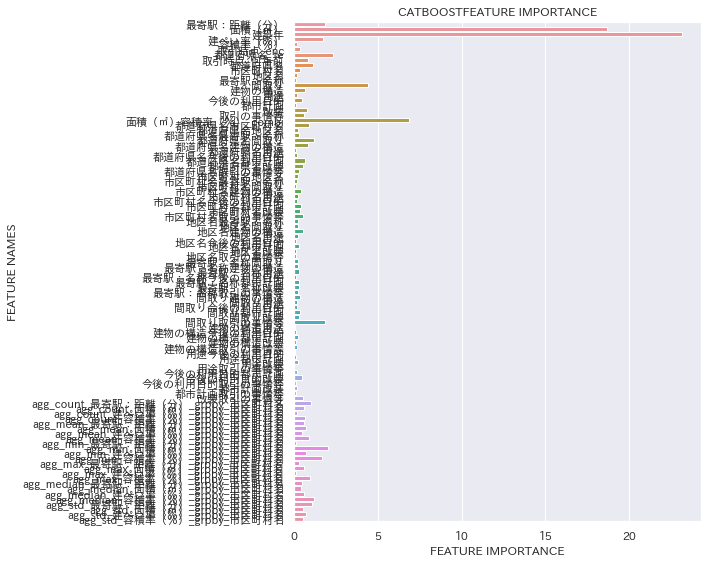

In [ ]:
#plot the catboost result
plot_feature_importance(optimised_model.get_feature_importance(),train_x.columns,'CATBOOST')
plt.tight_layout()
plt.savefig(dir_for_output + '/feature_importance.png')
plt.show()
plt.close()

In [ ]:
# CatBoost推論
y_pred = optimised_model.predict(test_x)

In [ ]:
test_df[TARGET] = y_pred

In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(dir_for_output + '/test_submission.csv', index=False)

In [ ]:
# モデルを保存する
import pickle

file = 'trained_model.pkl'
pickle.dump(optimised_model, open(dir_for_output + "/" + file, 'wb'))